In [1]:
import brainpy as bp
import brainpy.numpy as np
import bpmodels
import matplotlib.pyplot as plt

bp.profile.set(backend="numba", device='cpu', dt=.1, merge_steps=True)

In [2]:
import brainpy as bp
import brainpy.numpy as np
import sys

def get_AdExIF(V_rest=-65., V_reset=-68., V_th=-30., 
              V_T=-59.9, delta_T=3.48, a=1., b=1,
              R=1, C=10., tau=10., tau_w = 30.,
              t_refractory=1.7, noise=0., mode='scalar'):
    """Adaptive Exponential Integrate-and-Fire neuron model.
    
    .. math::
    
        \\tau_m\\frac{d V}{d t}= - (V-V_{rest}) + \\Delta_T e^{\\frac{V-V_T}{\\Delta_T}} - R w + RI(t)
    
        \\tau_w \\frac{d w}{d t}=a(V-V_{rest}) - w + b \\tau_w \\sum \\delta (t-t^f)


    ST refers to neuron state, members of ST are listed below:
    
    =============== ================= =========================================================
    **Member name** **Initial Value** **Explanation**
    --------------- ----------------- ---------------------------------------------------------
    V               0.                Membrane potential.

    w               0.                Adaptation current.
       
    input           0.                External and synaptic input current.
    
    spike           0.                Flag to mark whether the neuron is spiking. 
    
                                      Can be seen as bool.
                             
    refractory      0.                Flag to mark whether the neuron is in refractory period. 
     
                                      Can be seen as bool.
                             
    t_last_spike    -1e7              Last spike time stamp.
    =============== ================= =========================================================
    
    Note that all ST members are saved as floating point type in BrainPy, 
    though some of them represent other data types (such as boolean).
        
    Args:
        a (float):
        b (float):
        V_rest (float): Resting potential.
        V_reset (float): Reset potential after spike.
        V_th (float): Threshold potential of spike.
        V_T (float): Threshold potential of steady/non-steady.
        delta_T (float): Spike slope factor.
        R (float): Membrane resistance.
        C (float): Membrane capacitance.
        tau (float): Membrane time constant. Compute by R * C.
        tau_w (float): Time constant of the adaptation current.
        t_refractory (int): Refractory period length.
        noise (float): noise.   
        
    Returns:
        bp.Neutype: return description of ExpIF model.
    
    References:
        .. [1] Fourcaud-Trocmé, Nicolas, et al. "How spike generation 
               mechanisms determine the neuronal response to fluctuating 
               inputs." Journal of Neuroscience 23.37 (2003): 11628-11640.
    """

    ST = bp.types.NeuState(
        {'V': 0, 'w':0, 'input': 0, 'spike': 0, 'refractory': 0, 't_last_spike': -1e7}
    )

    @bp.integrate
    def int_V(V, _t_, w, I_ext):  # integrate u(t)
        return (- (V - V_rest) + delta_T * np.exp((V - V_T) / delta_T) - R * w + R * I_ext) / tau, noise / tau

    @bp.integrate
    def int_w(w, _t_, V):
        return (a * (V - V_rest)-w) / tau_w, noise / tau_w

    def update(ST, _t_):
        ST['spike'] = 0
        ST['refractory'] = True if _t_ - ST['t_last_spike'] <= t_refractory else False
        if not ST['refractory']:
            w = int_w(ST['w'], _t_, ST['V'])
            V = int_V(ST['V'], _t_, w, ST['input'])
            if V >= V_th:
                V = V_reset
                w += b
                ST['spike'] = 1
                ST['t_last_spike'] = _t_
            ST['V'] = V
            ST['w'] = w
            
    def reset(ST):
        ST['input'] = 0.

    
    if mode == 'scalar':
        return bp.NeuType(name='AdExIF_neuron',
                          requires=dict(ST=ST),
                          steps=(update, reset),
                          mode=mode)
    elif mode == 'vector':
        raise ValueError("mode of function '%s' can not be '%s'." % (sys._getframe().f_code.co_name, mode))
    elif mode == 'matrix':
        raise ValueError("mode of function '%s' can not be '%s'." % (sys._getframe().f_code.co_name, mode))
    else:
        raise ValueError("BrainPy does not support mode '%s'." % (mode))


In [3]:
import brainpy as bp
import sys

def get_AdQuaIF(a = 1, b = .1, a_0 = .07,  
                    V_c = -50, V_rest=-65., V_reset=-68., V_th=-30.,
                    R=1., C=10.,
                    tau=10., tau_w = 10., 
                    t_refractory=5., noise=0., mode='scalar'):
    """Adaptive Quadratic Integrate-and-Fire neuron model.
        
    .. math::

        \\tau_m \\frac{d V}{d t}=a_0(V-V_{rest})(V-V_c) - R w + RI(t)
        
        \\tau_w \\frac{d w}{d t}=a(V-V_{rest}) - w + b \\tau_w \\sum \\delta (t-t^f)
    
    ST refers to neuron state, members of ST are listed below:
    
    =============== ================= =========================================================
    **Member name** **Initial Value** **Explanation**
    --------------- ----------------- ---------------------------------------------------------
    V               0.                Membrane potential.

    w               0.                Adaptation current.
    
    input           0.                External and synaptic input current.
    
    spike           0.                Flag to mark whether the neuron is spiking. 
    
                                      Can be seen as bool.
                             
    refractory      0.                Flag to mark whether the neuron is in refractory period. 
     
                                      Can be seen as bool.
                             
    t_last_spike    -1e7              Last spike time stamp.
    =============== ================= =========================================================
    
    Note that all ST members are saved as floating point type in BrainPy, 
    though some of them represent other data types (such as boolean).
    
    Args:
        a (float):
        b (float):
        a_0 (float): Coefficient describes membrane potential update. Larger than 0.
        V_c (float): Critical voltage for spike initiation. Must be larger than V_rest.
        V_rest (float): Resting potential.
        V_reset (float): Reset potential after spike.
        V_th (float): Threshold potential of spike.
        R (float): Membrane resistance.
        C (float): Membrane capacitance.
        tau (float): Membrane time constant. Compute by R * C.
        tau_w (float): Time constant of the adaptation current.
        t_refractory (int): Refractory period length.(ms)
        noise (float): noise.   
        
    Returns:
        bp.Neutype: return description of QuaIF model.
        
    References:
        .. [1] Gerstner, Wulfram, et al. Neuronal dynamics: From single 
               neurons to networks and models of cognition. Cambridge 
               University Press, 2014.
    """

    if mode == 'vector':
        raise ValueError("mode of function '%s' can not be '%s'." % (sys._getframe().f_code.co_name, mode))
    elif mode == 'matrix':
        raise ValueError("mode of function '%s' can not be '%s'." % (sys._getframe().f_code.co_name, mode))
    elif mode != 'scalar':
        raise ValueError("BrainPy does not support mode '%s'." % (mode))


    ST = bp.types.NeuState(
        {'V': 0, 'w':0, 'input': 0, 'spike': 0, 'refractory': 0, 't_last_spike': -1e7}
    )

    @bp.integrate
    def int_V(V, _t_, w, I_ext):  
        return (a_0* (V - V_rest)*(V-V_c) - R * w + R * I_ext) / tau, noise / tau

    @bp.integrate
    def int_w(w, _t_, V):
        return (a* (V - V_rest)-w) / tau_w, noise / tau_w

    def update(ST, _t_):
        ST['spike'] = 0
        if _t_ - ST['t_last_spike'] <= t_refractory:
            ST['refractory'] = 1.
        else:
            ST['refractory'] = 0.
            w = int_w(ST['w'], _t_, ST['V'])
            V = int_V(ST['V'], _t_, w, ST['input'])
            if V >= V_th:
                V = V_reset
                w += b
                ST['spike'] = 1
                ST['t_last_spike'] = _t_
            ST['V'] = V
            ST['w'] = w

    def reset(ST):
        ST['input'] = 0.

    return bp.NeuType(name='AdQuaIF_neuron',
                      requires=dict(ST=ST),
                      steps=(update, reset),
                      mode=mode)    

In [4]:
def run_neuron(neu_type, I_ext=10., duration=100., ylim=False, title=''):
    neuron = bp.NeuGroup(neu_type, 1, monitors=['V'])

    neuron.run(duration=duration, inputs=["ST.input", I_ext])

    fig, gs = bp.visualize.get_figure(1, 1, 3, 5)

    fig.add_subplot(gs[0, 0])
    plt.plot(neuron.mon.ts, neuron.mon.V[:, 0], label='V')
    plt.ylabel('Membrane potential')
    plt.xlabel('Time (ms)')
    plt.xlim(-0.1, duration + 0.1)
    if ylim:
        plt.ylim(-95., 40.)
    plt.title(neu_type.name+title)
    plt.legend()

    plt.show()

tonic


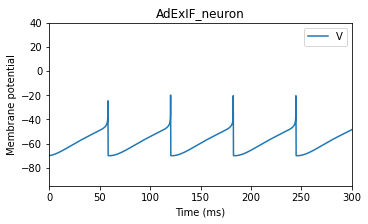

adapting


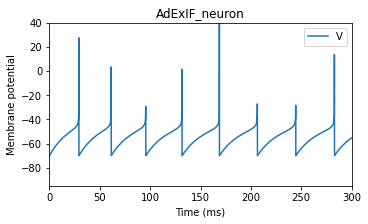

init_bursting


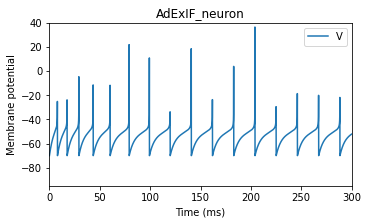

bursting


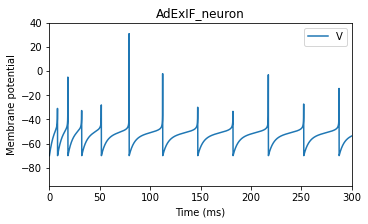

irregular


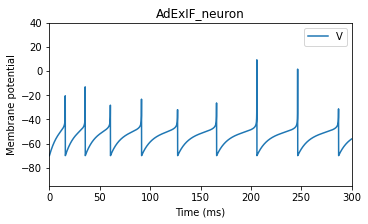

transient


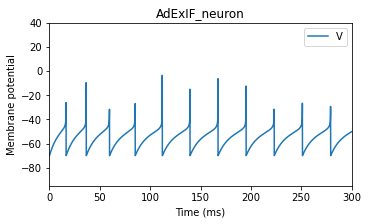

delayed


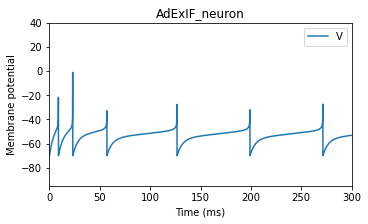

In [5]:
patterns = dict(tonic = [20, 0.0, 30.0, 60, -55],
                adapting = [20, 0., 100, 5, -55],
                init_bursting = [5., .5, 100, 7, -51],
                bursting = [5., -.5, 100, 7, -46],
                irregular = [9.9, -.5, 100, 7, -46],
                transient = [10, 1., 100, 10, -60],
                delayed = [5, -1, 100, 10, -60])

for i in patterns:
    print(i)
    i = patterns[i]
    neu = get_AdExIF(tau=i[0],t_refractory=0,
                    a=-i[1],
                    tau_w=i[2],
                    b=i[3],
                    V_reset=-70,
                    V_rest=-70,
                    R=.5,
                    delta_T=2.,
                    V_th=-i[4],
                    V_T=-50)
    run_neuron(neu, I_ext=65, duration=300., ylim=True)

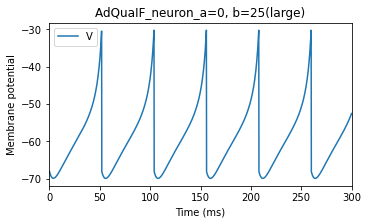

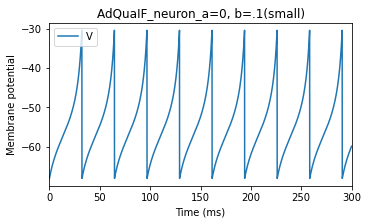

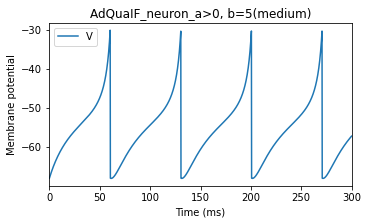

In [6]:
# test AdQuaIF
t_refractory=0.

# a=0, large b
aQIF = get_AdQuaIF(a=0, b=25, t_refractory=t_refractory)
run_neuron(aQIF, I_ext=10., duration=300., title='_a=0, b=25(large)')

# a=0, small b
aQIF = get_AdQuaIF(a=0, b=.1, t_refractory=t_refractory)
run_neuron(aQIF, I_ext=10., duration=300., title='_a=0, b=.1(small)')

# a>0, medium b
aQIF = get_AdQuaIF(a=.5, b=5, t_refractory=t_refractory)
run_neuron(aQIF, I_ext=10., duration=300., title='_a>0, b=5(medium)')

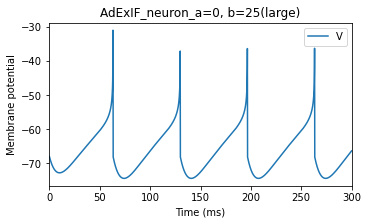

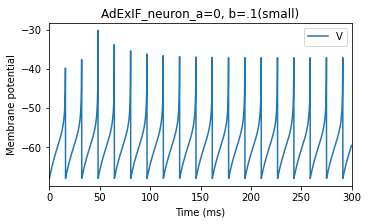

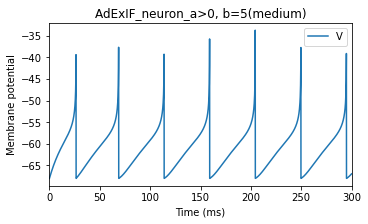

In [7]:
# test AdExIF
t_refractory=0.

# a=0, large b
aEIF = get_AdExIF(a=0, b=25, t_refractory=t_refractory)
run_neuron(aEIF, I_ext=10, duration=300., title='_a=0, b=25(large)')

# a=0, small b
aEIF = get_AdExIF(a=0, b=.1, t_refractory=t_refractory)
run_neuron(aEIF, I_ext=10, duration=300., title='_a=0, b=.1(small)')

# a>0, medium b
aEIF = get_AdExIF(a=1, b=5, t_refractory=t_refractory)
run_neuron(aEIF, I_ext=10, duration=300., title='_a>0, b=5(medium)')

#!!!problem!!!: a=0 -- no adaptation?
#larger a --> more adaptation

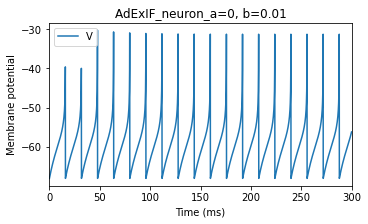

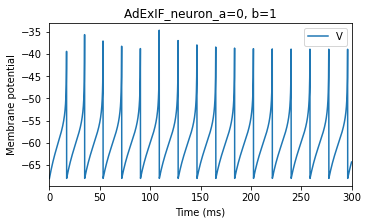

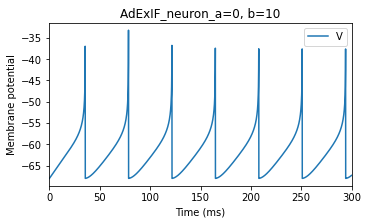

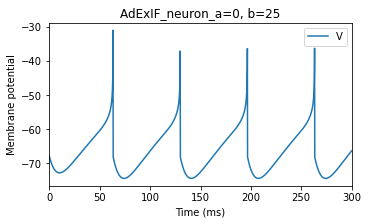

In [8]:
# test b
t_refractory=0.

# a=0, large b
bs=[.01, 1, 10, 25]
for b in bs:
    aEIF = get_AdExIF(a=0, b=b, t_refractory=t_refractory)
    run_neuron(aEIF, I_ext=10., duration=300., title='_a=0, b='+str(b))
    #aQIF = bpmodels.neurons.get_AdQuaIF(a=0, b=b, t_refractory=t_refractory)
    #run_neuron(aQIF, I_ext=15., duration=300., title='_a=0, b='+str(b))

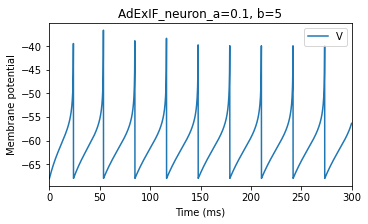

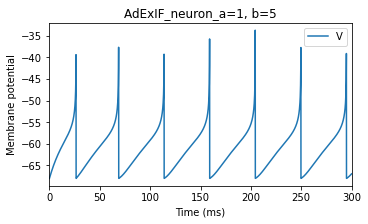

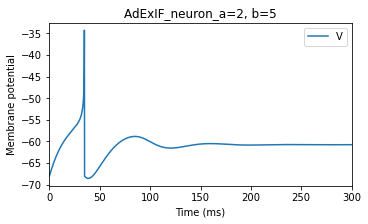

In [9]:
# test a

ass=[.1, 1, 2]
for a in ass:
    aEIF = get_AdExIF(a=a, b=5, t_refractory=t_refractory)
    run_neuron(aEIF, I_ext=10, duration=300., title='_a='+str(a)+', b=5')
    #aQIF = bpmodels.neurons.get_AdQuaIF(a=a, b=5, t_refractory=t_refractory)
    #run_neuron(aQIF, I_ext=20., duration=300., title='_a='+str(a)+', b=5(medium)')

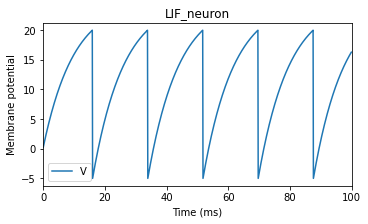

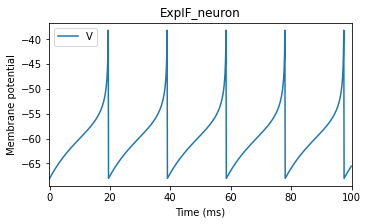

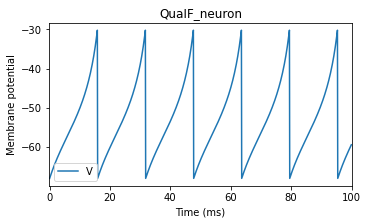

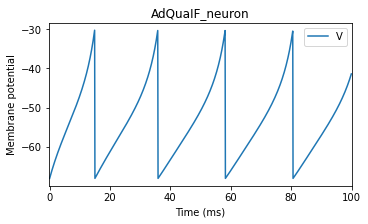

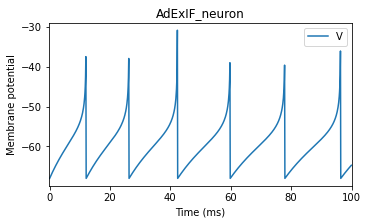

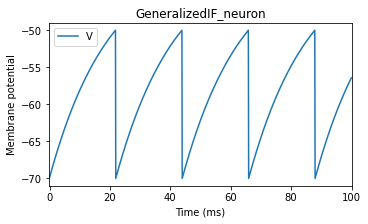

In [10]:
# Test all IF models with default parameters.

t_refractory=0.

LIF = bpmodels.neurons.get_LIF(t_refractory=t_refractory)
run_neuron(LIF, I_ext=25., duration=100.)

expIF = bpmodels.neurons.get_ExpIF(t_refractory=t_refractory)
run_neuron(expIF, I_ext=.8, duration=100.)

QIF = bpmodels.neurons.get_QuaIF(t_refractory=t_refractory)
run_neuron(QIF, I_ext=20., duration=100.)

aQIF = bpmodels.neurons.get_AdQuaIF(t_refractory=t_refractory)
run_neuron(aQIF, I_ext=25., duration=100.)

aEIF = bpmodels.neurons.get_AdExIF(t_refractory=t_refractory)
run_neuron(aEIF, I_ext=15., duration=100.)

gIF = bpmodels.neurons.get_GeneralizedIF()
run_neuron(gIF, I_ext=1.5, duration=100.)